In [ ]:
from PIL import Image
from pathlib import Path
import numpy as np

# Data Pre-processing
## Create RGB patches

In [67]:
def create_rgb_pil (red_filename: Path):
    
    # set the filenames for each patch
    red_fn = str(red_filename)
    blue_fn = red_fn.replace('red','blue')
    green_fn = red_fn.replace('red', 'green')
    rgb_fn = red_fn.replace('red', 'rgb').replace('.TIF', '.png')
    
    # open red, green and blue patches as numpy arrays
    arr_red = np.array(Image.open(red_fn))
    arr_green = np.array(Image.open(green_fn))
    arr_blue = np.array(Image.open(blue_fn))
    
    # stack them into a single 384x384x3 RGB array
    arr_rgb = np.stack([arr_red, arr_green, arr_blue], axis=2)
    
    # as the original TIF values are UINT16 with absolute values up to 65535, we normalize them 
    # between 0 and 1
    arr_rgb = arr_rgb / np.iinfo(arr_rgb.dtype).max
    
    # create RGB PIL image 
    rgb = Image.fromarray((256*arr_rgb).astype(np.uint8), 'RGB')
    
    # save the image into output folder
    rgb.save(rgb_fn)
    
    return rgb
    
    

In [ ]:
# sets the base path
base_path = Path('D:/DeepLearning/38cloud_images/38-Cloud_training/')

# create the rgb output dir
if not (base_path/'train_rgb').exists():
    (base_path/'train_rgb').mkdir()

# loop trough the red patches and create the corresponding rgb ones
for red_patch in (base_path/'train_red').iterdir():
    create_rgb_pil(red_patch)

## Convert Ground Truth to PNG

In [98]:
def convert_tif_png(tif_filename: Path, out_folder:Path):
    # Open mask with PIL 
    arr_tif = np.array(Image.open(tif_filename))

    # change values from 255 to 1
    im = Image.fromarray(np.where(arr_tif==255, 1, 0))

    im.save(out_folder/tif_filename.with_suffix('.png').name)
    
    return im


In [100]:
# sets the base path
base_path = Path('D:/DeepLearning/38cloud_images/38-Cloud_training/')

# create the rgb output dir
if not (base_path/'labels').exists():
    (base_path/'labels').mkdir()

# loop trough the red patches and create the corresponding rgb ones
for gt_patch in (base_path/'train_gt').iterdir():
    convert_tif_png(gt_patch, base_path/'labels')

After finishing the pre-processing step, we should organize the data into data/images and data/labels folders. Let's create a data folder, move train_rgb and labels into it and then rename train_rgb into images. 

# Creating the Data Loader

In [110]:
from fastai.vision import *

path_data = Path('D:/DeepLearning/38cloud_images/38-Cloud_training/data')

path_lbl = path_data/'labels'
path_img = path_data/'images'

# get images and labels filenames
img_names = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

print(len(img_names), len(lbl_names))

8400 8400


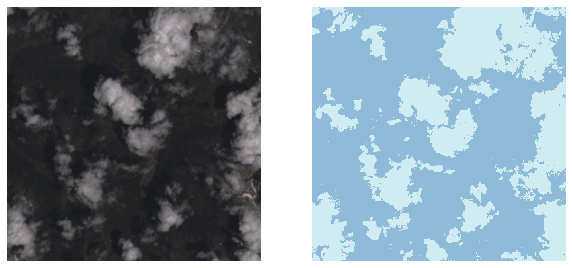

In [160]:
import matplotlib.pyplot as plt

def get_lbl_fn(img_fn: Path):  
  
  img_name = img_fn.name
  lbl_name = img_name.replace('rgb', 'gt')

  return img_fn.parent.parent/('labels/' + lbl_name)

fname = Path('D:/DeepLearning/38cloud_images/38-Cloud_training/data/images/rgb_patch_200_10_by_11_LC08_L1TP_034034_20160520_20170223_01_T1.png')

img = open_image(fname)
mask = open_mask(get_lbl_fn(fname))

fig, ax = plt.subplots(1,2, figsize=(10,6))

img.show(ax[0])
mask.show(ax[1])

In [164]:
src = (SegmentationItemList
       .from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_lbl_fn, classes=['clear', 'cloud']))

data = (src.transform(get_transforms(flip_vert=True), size=384, tfm_y=True)
        .databunch(bs=4)
        .normalize(imagenet_stats))

data

ImageDataBunch;

Train: LabelList (6720 items)
x: SegmentationItemList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: SegmentationLabelList
ImageSegment (1, 384, 384),ImageSegment (1, 384, 384),ImageSegment (1, 384, 384),ImageSegment (1, 384, 384),ImageSegment (1, 384, 384)
Path: D:\DeepLearning\38cloud_images\38-Cloud_training\data\images;

Valid: LabelList (1680 items)
x: SegmentationItemList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: SegmentationLabelList
ImageSegment (1, 384, 384),ImageSegment (1, 384, 384),ImageSegment (1, 384, 384),ImageSegment (1, 384, 384),ImageSegment (1, 384, 384)
Path: D:\DeepLearning\38cloud_images\38-Cloud_training\data\images;

Test: None

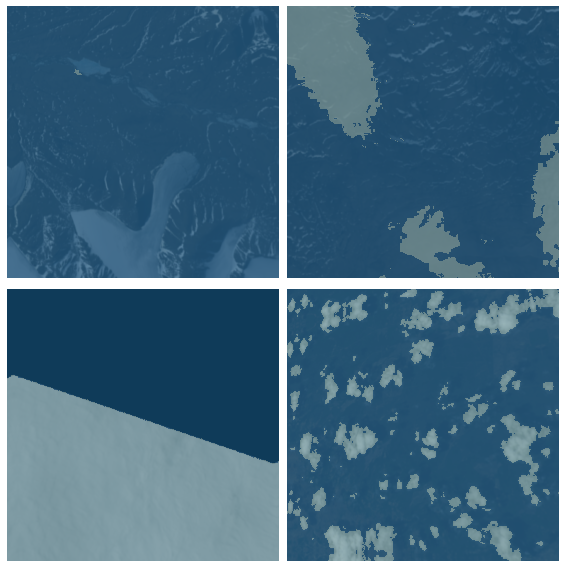

In [175]:
data.show_batch(2)

# The Model

In [180]:
def acc_metric(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

wd = 1e-2

lr=1e-3

learn = unet_learner(data, models.resnet34, metrics=acc_metric, wd=wd)

learn.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,acc_metric,time
0,0.247730,0.132063,0.950202,15:02
1,0.142790,0.118204,0.953499,14:41
2,0.120431,0.101199,0.960386,14:42


In [184]:
learn.save('38_cloud_medium_Resnet34')

In [ ]:
img = learn.data.valid_ds.x[22]
mask = learn.data.valid_ds.y[22]
pred = learn.predict(img)[0]

fig, ax = plt.subplots(1,3, figsize=(12,6))

img.show(ax[0])
mask.show(ax[1])
pred.show(ax[2])

In [ ]:
prediction = learn.predict(img)
prediction[0]

epoch,train_loss,valid_loss,acc_metric,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


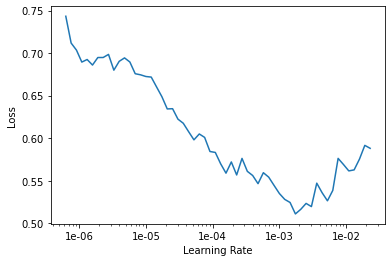

In [181]:
lr_find(learn)
learn.recorder.plot()

# The Results

In [ ]:
#save the model
learn.save('38_cloud_medium_Resnet34')

# select one image from the validation dataset
img = learn.data.valid_ds.x[22]
mask = learn.data.valid_ds.y[22]
pred = learn.predict(img)[0]

fig, ax = plt.subplots(1,3, figsize=(12,6))

img.show(ax[0])
mask.show(ax[1])
pred.show(ax[2])